In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
from tensorflow.keras.datasets import cifar10 
from keras.datasets import fashion_mnist 
from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 10
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    tmp, tmp2 = [], []

    num_pick = random.randint(1000, 5000 ) #변동 사항 #int(len(list(x_train_range))/local)
    num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
    
    tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), num_pick2)

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
    
    print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  2881    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  2871    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  3339    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  2912    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  2142    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  2053    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1796    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  4795    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  4312    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  3985    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  1996    Number of Trainin

In [7]:
#준비된 데이터 (IID / NON-IID) np.array로

local = 21
best_Sil_score_c = []
Silhouette_sc_c = []

global_epoch = 0
acc, loss = 0, 0
cluster_acc, cluster_loss, Cluster_ACC, Cluster_LOSS = [], [], [], [] 
num_layers_list = [0,2,4,6,7]
label_list = []
VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    cluster_acc.append(acc)  #acc 넣기
    cluster_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        TMP_w = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][0]).reshape(-1))
        TMP_b = list(np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)][1]).reshape(-1))
        
        TMP_w.extend(TMP_b) ##append 말고 더해야함..

        TMP_w = np.array(TMP_w)
        TMP_w = list(TMP_w.reshape(-1))
        globals()['layer{}_W_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도
  

    #----------------------------------------------------클러스터링 실시 -------------------------------------------------------------
    silhoutte_score_w = []
    transformed = globals()['layer{}_W_tmp'.format(layer_index)]

    for clusters in range((int(local/2)-1)):       ####=>  이 범위 : 클러스터 갯수, 밑에 보면 cluster+2 있음 = 총 10개 => (0,11) = 10                                                       
        kmeans_model_w = KMeans(n_clusters=clusters+2)   # 0, 1은 silhouette 에 안먹힘  

        kmeans_model_w.fit(transformed)       #레이블 정의 

        silhoutte_score_w.append(silhouette_score(globals()['layer{}_W_tmp'.format(layer_index)], kmeans_model_w.labels_, metric='euclidean'))  

    num_clusters_for_w = np.argmax(silhoutte_score_w) 
    best_Sil_score_c.append(silhoutte_score_w[num_clusters_for_w])  # 처음에는 둘 다 넣어줌

    kmeans_model_w = KMeans(n_clusters=num_clusters_for_w+2)   # 0, 1은 silhouette 에 안먹힘  

    globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 

    globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = num_clusters_for_w + 2  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
    
    label_list.append(globals()['w_layer{}_label'.format(layer_index)])                 
    print("Layer : ", layer_index, "  클러스터 갯수 정해짐!  갯수 : ", globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)], num_clusters_for_w) ########################################################******************************************

    # ==========> 클러스터 갯수 정해짐


    #----------------------------------------------- 스케일링  ---------------------------------------------------------------------
    for num_c_w in range(num_clusters_for_w+2): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0  #각각 cluster, Act+cluster 용도  
        
        globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
    
        for i in range(1, local):
            if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링
                
                globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

        globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
        globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])

#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------

transformed = 0
Silhouette_sc_c.append(best_Sil_score_c)
Cluster_ACC.append(cluster_acc)
Cluster_LOSS.append(cluster_loss)

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비

# Weight, bias 합친 것
 # FedAvg                   :  G{}_w_layer
 # 일반 클러스터링          :  G{}_c{}_w_layer{}               클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w
 # Actiavtion + 클러스터링  :  G{}_c{}_w_layer{}_Act           클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w_c_a



 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5434 - accuracy: 0.8256
15/15 - 0s - loss: 0.5523 - accuracy: 0.8088
15/15 - 0s - loss: 0.4732 - accuracy: 0.8235
15/15 - 0s - loss: 0.5222 - accuracy: 0.8235
15/15 - 0s - loss: 0.6126 - accuracy: 0.7983
15/15 - 0s - loss: 0.5459 - accuracy: 0.7983
15/15 - 0s - loss: 0.6124 - accuracy: 0.7899
15/15 - 0s - loss: 0.4912 - accuracy: 0.8193
15/15 - 0s - loss: 0.5381 - accuracy: 0.8277
15/15 - 0s - loss: 0.4547 - accuracy: 0.8445
15/15 - 0s - loss: 0.4990 - accuracy: 0.8214
15/15 - 0s - loss: 0.6158 - accuracy: 0.7563
15/15 - 0s - loss: 0.5718 - accuracy: 0.8046
15/15 - 0s - loss: 0.4602 - accuracy: 0.8382
15/15 - 0s - loss: 0.5051 - accuracy: 0.8361
15/15 - 0s - loss: 0.6212 - accuracy: 0.7941
15/15 - 0s - loss: 0.5347 - accuracy: 0.8151
15/15 - 0s - loss: 0.5546 - accuracy: 0.8004
15/15 - 0s - loss: 0.5241 - accuracy: 0.8172
15/15 - 0s - loss: 0.5396 - accuracy: 0.8172
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-7-32b596a4692c>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-32b596a4692c>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-32b596a4692c>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-32b596a4692c>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-7-32b596a4692c>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w'.format(i,layer_index)])          # 일반 클러스터링


In [8]:
G_epoch = 51

for global_epoch in range(1, G_epoch):

    for i in range(1, local):
        if global_epoch == 1:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #모델 넣어줌 (우리는 구조만 필요한 것)
        else:
            globals()['G{}_c_L{}_model'.format(global_epoch, i)] = globals()['G{}_c_L{}_model'.format(global_epoch-1, i)]   #모델 넣어줌 (우리는 구조만 필요한 것)

        for layer_index in num_layers_list: 
            num_c = globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch-1, layer_index)]   
    
            for ccc in range(num_c):
                if globals()['w_layer{}_label'.format(layer_index)][i-1] == ccc:    #현재 로컬 레이어의 군집 결과 == ccc
                    globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].set_weights(globals()['G{}_c{}_w_layer{}'.format(global_epoch-1, ccc, layer_index) ])  # 클러스터용 로컬 모델 선언
                    
                  
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")


    for i in range(1,local):
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  
        
    for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

        x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
        x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

        tmp, tmp2 = [], []

        num_pick = random.randint(1000, int(len(list(x_train_range))/local) ) #변동 사항
        num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함

        tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), num_pick2)

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== Cluster  ========================================================================  같이 했음. 왜냐면 cluster 하고 나서 activation 을 씌우는 거라 cluster까지는 같음

    cluster_acc, cluster_loss, cluster_act_acc, cluster_act_loss, now = [], [], [], [], time.time()
    
    for i in range(1, local):
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])  #Cluster => 알맞는 클러스터에 넣기
        globals()['G{}_c_L{}_model'.format(global_epoch, i)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
        loss, acc = globals()['G{}_c_L{}_model'.format(global_epoch, i)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        cluster_acc.append(acc)  #acc 넣기
        cluster_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < Clustering > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            
            globals()['L{}_layer{}_w_c'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 
            globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)]   = globals()['G{}_c_L{}_model'.format(global_epoch, i)].layers[layer_index].get_weights() # Clustering 

    #------------------------------------------------ 클러스터링만 한 값들 Clustering --------------------------------------------------------
    for layer_index in num_layers_list:
        best_Sil_score_c = []
        globals()['layer{}_W_c_tmp'.format(layer_index)] = []
        
        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
            
        for i in range(1, local):
            TMP_w = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][0]).reshape(-1))
            TMP_b = list(np.array(globals()['L{}_layer{}_w_c_tmp'.format(i,layer_index)][1]).reshape(-1))
            
            TMP_w.extend(TMP_b) ##append 말고 더해야함..

            TMP_w = np.array(TMP_w)
            TMP_w = list(TMP_w.reshape(-1))
            globals()['layer{}_W_c_tmp'.format(layer_index)].append(TMP_w)  #클러스터링 용도

        #---------------------------------------------------- 실루엣 기반 클러스터링 실시 -------------------------------------------------------------
        silhoutte_score_w = []
        transformed = globals()['layer{}_W_c_tmp'.format(layer_index)]

        for clusters in range((int(local/2)-1)):       ####=>  이 범위 : 클러스터 갯수, 밑에 보면 cluster+2 있음 = 총 10개 => (0,11) = 10
            globals()['w_layer{}_label'.format(layer_index)] = 0
                                                            
            kmeans_model_w = KMeans(n_clusters=clusters+2)   # 0, 1은 silhouette 에 안먹힘  

            kmeans_model_w.fit(transformed)       #레이블 정의 

            silhoutte_score_w.append(silhouette_score(globals()['layer{}_W_tmp'.format(layer_index)], kmeans_model_w.labels_, metric='euclidean'))  
            
        num_clusters_for_w = np.argmax(silhoutte_score_w)  
        best_Sil_score_c.append(silhoutte_score_w[num_clusters_for_w])
 
        kmeans_model_w = KMeans(n_clusters=num_clusters_for_w+2)   # 0, 1은 silhouette 에 안먹힘  

        globals()['w_layer{}_label'.format(layer_index)] = kmeans_model_w.fit_predict(transformed)       # 가장 적합한 클러스터로 레이어에 속한 로컬들 레이블 정의 
        label_list.append(globals()['w_layer{}_label'.format(layer_index)])

        globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)] = num_clusters_for_w + 2  #나중에 몇개로 나뉘었는지 알아야 함 = num_clusters_for_w이거 그대로 하면 밑에 저게 쓸일이 많아서 global 쓰면 코딩이 너무 번잡해짐;; 
        print("Layer : ", layer_index, "  클러스터 갯수 정해짐!  갯수 : ", globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)], num_clusters_for_w) ########################################################******************************************


        #----------------------------------------------- 스케일링 및 업데이트 ---------------------------------------------------------------------
        for num_c_w in range(num_clusters_for_w+2): #클러스터 갯수 (num_clusters_for_w) 만큼 클러스터용 = 클러스터 갯수가 3이 나왔으면 3개를 만들어야 함
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = 0 
            
            globals()['w_scaler_c{}_sum'.format(num_c_w)], globals()['int_c{}_w'.format(num_c_w)] = 0, 0 #초기화
        
            for i in range(1, local):

                if globals()['w_layer{}_label'.format(layer_index)][i-1] == num_c_w  : # 클러스터 레이블에 맞게 (0 or 1 or 2 ..) 
                    globals()['w_scaler_c{}_sum'.format(num_c_w)] = globals()['w_scaler_c{}_sum'.format(num_c_w)] + len(globals()['L{}_x_train'.format(i)])

                    globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링
                  
                    globals()['int_c{}_w'.format(num_c_w)] = globals()['int_c{}_w'.format(num_c_w)] + 1

            globals()['w_scaler{}'.format(num_c_w)] = len(globals()['L{}_x_train'.format(i)]) / globals()['w_scaler_c{}_sum'.format(num_c_w)]
            globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] / globals()['int_c{}_w'.format(num_c_w)] #레이어 별 클러스터 자기 갯수만큼 나눠주기=평균

        
        sum_for_var_w,sum_for_var_b = 0, 0
        for sps in range(num_clusters_for_w+2):
            sum_for_var_w = sum_for_var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, 0, layer_index)][0]
            sum_for_var_b = sum_for_var_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, 0, layer_index)][1] 
        
        sum_for_var_w = sum_for_var_w/(num_clusters_for_w+2)
        sum_for_var_b = sum_for_var_b/(num_clusters_for_w+2)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(sum_for_var_w))
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(sum_for_var_b))
  

        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])


    Cluster_ACC.append(cluster_acc)
    Cluster_LOSS.append(cluster_loss)
    Silhouette_sc_c.append(best_Sil_score_c)


    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")


1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6422 - accuracy: 0.7500
15/15 - 0s - loss: 0.7067 - accuracy: 0.7416
15/15 - 0s - loss: 0.7958 - accuracy: 0.7080
15/15 - 0s - loss: 0.6958 - accuracy: 0.7416
15/15 - 0s - loss: 0.6970 - accuracy: 0.7416
15/15 - 0s - loss: 0.8576 - accuracy: 0.6387
15/15 - 0s - loss: 0.8759 - accuracy: 0.6786
15/15 - 0s - loss: 0.6181 - accuracy: 0.7479
15/15 - 0s - loss: 0.5424 - accuracy: 0.8256
15/15 - 0s - loss: 0.6568 - accuracy: 0.7710
15/15 - 0s - loss: 0.7818 - accuracy: 0.7206
15/15 - 0s - loss: 0.7427 - accuracy: 0.7164
15/15 - 0s - loss: 0.9164 - accuracy: 0.6576
15/15 - 0s - loss: 0.8299 - accuracy: 0.6807
15/15 - 0s - loss: 0.7815 - accuracy: 0.7143
15/15 - 0s - loss: 0.7598 - accuracy: 0.7080
15/15 - 0s - loss: 0.8998 - accuracy: 0.6534
15/15 - 0s - loss: 0.7745 - accuracy: 0.6933
15/15 - 0s - loss: 0.7314 - accuracy: 0.7332
15/15 - 0s - loss: 0.7910 - 

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


2  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6275 - accuracy: 0.7815
15/15 - 0s - loss: 0.6979 - accuracy: 0.7542
15/15 - 0s - loss: 0.5963 - accuracy: 0.7815
15/15 - 0s - loss: 0.6206 - accuracy: 0.7794
15/15 - 0s - loss: 0.6447 - accuracy: 0.7626
15/15 - 0s - loss: 0.6779 - accuracy: 0.7584
15/15 - 0s - loss: 0.5618 - accuracy: 0.7941
15/15 - 0s - loss: 0.6848 - accuracy: 0.7164
15/15 - 0s - loss: 0.6492 - accuracy: 0.7584
15/15 - 0s - loss: 0.6536 - accuracy: 0.7584
15/15 - 0s - loss: 0.5948 - accuracy: 0.7920
15/15 - 0s - loss: 0.8015 - accuracy: 0.7458
15/15 - 0s - loss: 0.6539 - accuracy: 0.7479
15/15 - 0s - loss: 0.6930 - accuracy: 0.7374
15/15 - 0s - loss: 0.6929 - accuracy: 0.7395
15/15 - 0s - loss: 0.6871 - accuracy: 0.7731
15/15 - 0s - loss: 0.7031 - accuracy: 0.7227
15/15 - 0s - loss: 0.6418 - accuracy: 0.7689
15/15 - 0s - loss: 0.6010 - accuracy: 0.7857
15/15 - 0s - loss: 0.6183 - accuracy: 0.7689
------------    

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


3  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


3  번째 global_epoch 데이터 랜덤 준비완료!!


3  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6551 - accuracy: 0.7773
15/15 - 0s - loss: 0.7539 - accuracy: 0.7227
15/15 - 0s - loss: 0.7231 - accuracy: 0.7584
15/15 - 0s - loss: 0.6313 - accuracy: 0.8046
15/15 - 0s - loss: 0.5695 - accuracy: 0.8004
15/15 - 0s - loss: 0.5841 - accuracy: 0.7962
15/15 - 0s - loss: 0.6773 - accuracy: 0.7710
15/15 - 0s - loss: 0.7281 - accuracy: 0.7437
15/15 - 0s - loss: 0.5996 - accuracy: 0.7794
15/15 - 0s - loss: 0.6873 - accuracy: 0.7626
15/15 - 0s - loss: 0.6681 - accuracy: 0.7815
15/15 - 0s - loss: 0.5908 - accuracy: 0.7773
15/15 - 0s - loss: 0.6351 - accuracy: 0.7710
15/15 - 0s - loss: 0.5519 - accuracy: 0.7857
15/15 - 0s - loss: 0.5445 - accuracy: 0.8004
15/15 - 0s - loss: 0.6238 - accuracy: 0.7710
15/15 - 0s - loss: 0.4717 - accuracy: 0.8235
15/15 - 0s - loss: 0.7126 - accuracy: 0.7731
15/15 - 0s - loss: 0.6253 - accuracy: 0.7878
15/15 - 0s - loss: 0.6128 - accuracy: 0.7731
------------    

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


4  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


4  번째 global_epoch 데이터 랜덤 준비완료!!


4  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6234 - accuracy: 0.7899
15/15 - 0s - loss: 0.6864 - accuracy: 0.7878
15/15 - 0s - loss: 0.6709 - accuracy: 0.8046
15/15 - 0s - loss: 0.5737 - accuracy: 0.8172
15/15 - 0s - loss: 0.5693 - accuracy: 0.8109
15/15 - 0s - loss: 0.6328 - accuracy: 0.7668
15/15 - 0s - loss: 0.5973 - accuracy: 0.7899
15/15 - 0s - loss: 0.4962 - accuracy: 0.8256
15/15 - 0s - loss: 0.6075 - accuracy: 0.8004
15/15 - 0s - loss: 0.6228 - accuracy: 0.8067
15/15 - 0s - loss: 0.6013 - accuracy: 0.8004
15/15 - 0s - loss: 0.6182 - accuracy: 0.7920
15/15 - 0s - loss: 0.6066 - accuracy: 0.7899
15/15 - 0s - loss: 0.5180 - accuracy: 0.8151
15/15 - 0s - loss: 0.6093 - accuracy: 0.7899
15/15 - 0s - loss: 0.5738 - accuracy: 0.7773
15/15 - 0s - loss: 0.6109 - accuracy: 0.8151
15/15 - 0s - loss: 0.6507 - accuracy: 0.7815
15/15 - 0s - loss: 0.6455 - accuracy: 0.7752
15/15 - 0s - loss: 0.6315 - accuracy: 0.7857
------------    

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


5  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


5  번째 global_epoch 데이터 랜덤 준비완료!!


5  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6760 - accuracy: 0.7815
15/15 - 0s - loss: 0.6117 - accuracy: 0.7689
15/15 - 0s - loss: 0.4872 - accuracy: 0.8361
15/15 - 0s - loss: 0.5739 - accuracy: 0.8130
15/15 - 0s - loss: 0.6433 - accuracy: 0.7710
15/15 - 0s - loss: 0.5564 - accuracy: 0.8067
15/15 - 0s - loss: 0.5883 - accuracy: 0.7899
15/15 - 0s - loss: 0.5062 - accuracy: 0.8151
15/15 - 0s - loss: 0.5005 - accuracy: 0.8193
15/15 - 0s - loss: 0.6418 - accuracy: 0.7857
15/15 - 0s - loss: 0.5948 - accuracy: 0.8130
15/15 - 0s - loss: 0.5972 - accuracy: 0.8193
15/15 - 0s - loss: 0.6291 - accuracy: 0.8046
15/15 - 0s - loss: 0.6779 - accuracy: 0.7920
15/15 - 0s - loss: 0.6746 - accuracy: 0.7815
15/15 - 0s - loss: 0.6172 - accuracy: 0.8193
15/15 - 0s - loss: 0.5587 - accuracy: 0.8340
15/15 - 0s - loss: 0.7576 - accuracy: 0.7647
15/15 - 0s - loss: 0.6058 - accuracy: 0.7815
15/15 - 0s - loss: 0.5615 - accuracy: 0.8151
------------    

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


6  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


6  번째 global_epoch 데이터 랜덤 준비완료!!


6  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5099 - accuracy: 0.8193
15/15 - 0s - loss: 0.5112 - accuracy: 0.8235
15/15 - 0s - loss: 0.5682 - accuracy: 0.8193
15/15 - 0s - loss: 0.5796 - accuracy: 0.8298
15/15 - 0s - loss: 0.5808 - accuracy: 0.7983
15/15 - 0s - loss: 0.6008 - accuracy: 0.8235
15/15 - 0s - loss: 0.6688 - accuracy: 0.8046
15/15 - 0s - loss: 0.6992 - accuracy: 0.8151
15/15 - 0s - loss: 0.5729 - accuracy: 0.8130
15/15 - 0s - loss: 0.7707 - accuracy: 0.7836
15/15 - 0s - loss: 0.6029 - accuracy: 0.8046
15/15 - 0s - loss: 0.6671 - accuracy: 0.8256
15/15 - 0s - loss: 0.7690 - accuracy: 0.7878
15/15 - 0s - loss: 0.7634 - accuracy: 0.7815
15/15 - 0s - loss: 0.5224 - accuracy: 0.8172
15/15 - 0s - loss: 0.8595 - accuracy: 0.7752
15/15 - 0s - loss: 0.6463 - accuracy: 0.8088
15/15 - 0s - loss: 0.6193 - accuracy: 0.8403
15/15 - 0s - loss: 0.7074 - accuracy: 0.8193
15/15 - 0s - loss: 0.5669 - accuracy: 0.8109
------------    

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


7  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5254 - accuracy: 0.8235
15/15 - 0s - loss: 0.6881 - accuracy: 0.8046
15/15 - 0s - loss: 0.5633 - accuracy: 0.8445
15/15 - 0s - loss: 0.5935 - accuracy: 0.8319
15/15 - 0s - loss: 0.4377 - accuracy: 0.8592
15/15 - 0s - loss: 0.6548 - accuracy: 0.8088
15/15 - 0s - loss: 0.6012 - accuracy: 0.8340
15/15 - 0s - loss: 0.4465 - accuracy: 0.8803
15/15 - 0s - loss: 0.6385 - accuracy: 0.8046
15/15 - 0s - loss: 0.5821 - accuracy: 0.8382
15/15 - 0s - loss: 0.9331 - accuracy: 0.7920
15/15 - 0s - loss: 0.5670 - accuracy: 0.8214
15/15 - 0s - loss: 0.6548 - accuracy: 0.8067
15/15 - 0s - loss: 0.6053 - accuracy: 0.8109
15/15 - 0s - loss: 0.6006 - accuracy: 0.8193
15/15 - 0s - loss: 0.6377 - accuracy: 0.8067
15/15 - 0s - loss: 0.6402 - accuracy: 0.8088
15/15 - 0s - loss: 0.5170 - accuracy: 0.8424
15/15 - 0s - loss: 0.6184 - accuracy: 0.8193
15/15 - 0s - loss: 0.6655 - accuracy: 0.7941
------------    

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


8  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


8  번째 global_epoch 데이터 랜덤 준비완료!!


8  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6404 - accuracy: 0.8193
15/15 - 0s - loss: 0.6289 - accuracy: 0.8298
15/15 - 0s - loss: 0.6788 - accuracy: 0.8277
15/15 - 0s - loss: 0.6274 - accuracy: 0.8445
15/15 - 0s - loss: 0.7924 - accuracy: 0.8067
15/15 - 0s - loss: 0.5990 - accuracy: 0.8298
15/15 - 0s - loss: 0.6311 - accuracy: 0.8214
15/15 - 0s - loss: 0.5978 - accuracy: 0.8466
15/15 - 0s - loss: 0.6057 - accuracy: 0.8382
15/15 - 0s - loss: 0.5656 - accuracy: 0.8529
15/15 - 0s - loss: 0.6680 - accuracy: 0.8046
15/15 - 0s - loss: 0.6589 - accuracy: 0.8403
15/15 - 0s - loss: 0.6009 - accuracy: 0.8382
15/15 - 0s - loss: 0.5528 - accuracy: 0.8361
15/15 - 0s - loss: 0.6129 - accuracy: 0.8445
15/15 - 0s - loss: 0.8290 - accuracy: 0.7962
15/15 - 0s - loss: 0.6404 - accuracy: 0.8298
15/15 - 0s - loss: 0.6591 - accuracy: 0.8319
15/15 - 0s - loss: 0.6503 - accuracy: 0.8382
15/15 - 0s - loss: 0.5248 - accuracy: 0.8487
------------    

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  4 2


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6155 - accuracy: 0.8403
15/15 - 0s - loss: 0.5739 - accuracy: 0.8319
15/15 - 0s - loss: 0.7540 - accuracy: 0.8298
15/15 - 0s - loss: 0.6144 - accuracy: 0.8508
15/15 - 0s - loss: 0.4540 - accuracy: 0.8508
15/15 - 0s - loss: 0.7674 - accuracy: 0.8403
15/15 - 0s - loss: 0.6945 - accuracy: 0.8319
15/15 - 0s - loss: 0.6155 - accuracy: 0.8214
15/15 - 0s - loss: 0.7232 - accuracy: 0.8088
15/15 - 0s - loss: 0.5852 - accuracy: 0.8529
15/15 - 0s - loss: 0.6540 - accuracy: 0.8319
15/15 - 0s - loss: 0.6320 - accuracy: 0.8256
15/15 - 0s - loss: 0.6552 - accuracy: 0.8046
15/15 - 0s - loss: 0.6268 - accuracy: 0.8424
15/15 - 0s - loss: 0.7785 - accuracy: 0.8109
15/15 - 0s - loss: 0.4869 - accuracy: 0.8634
15/15 - 0s - loss: 0.5718 - accuracy: 0.8487
15/15 - 0s - loss: 0.7422 - accuracy: 0.8277
15/15 - 0s - loss: 0.6988 - accuracy: 0.8151
15/15 - 0s - loss: 0.7502 - accuracy: 0.7773
------------    

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  4 2


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


10  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


10  번째 global_epoch 데이터 랜덤 준비완료!!


10  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5618 - accuracy: 0.8403
15/15 - 0s - loss: 0.7241 - accuracy: 0.8340
15/15 - 0s - loss: 0.6161 - accuracy: 0.8130
15/15 - 0s - loss: 0.6864 - accuracy: 0.8445
15/15 - 0s - loss: 0.5363 - accuracy: 0.8571
15/15 - 0s - loss: 0.6354 - accuracy: 0.8403
15/15 - 0s - loss: 0.5955 - accuracy: 0.8508
15/15 - 0s - loss: 0.5506 - accuracy: 0.8592
15/15 - 0s - loss: 0.7580 - accuracy: 0.7878
15/15 - 0s - loss: 0.5889 - accuracy: 0.8613
15/15 - 0s - loss: 0.6965 - accuracy: 0.8445
15/15 - 0s - loss: 0.7509 - accuracy: 0.7941
15/15 - 0s - loss: 0.5508 - accuracy: 0.8529
15/15 - 0s - loss: 0.7073 - accuracy: 0.8298
15/15 - 0s - loss: 0.5946 - accuracy: 0.8235
15/15 - 0s - loss: 0.8146 - accuracy: 0.8130
15/15 - 0s - loss: 0.7110 - accuracy: 0.8235
15/15 - 0s - loss: 0.5582 - accuracy: 0.8697
15/15 - 0s - loss: 0.5891 - accuracy: 0.8340
15/15 - 0s - loss: 0.7798 - accuracy: 0.8508
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  4 2


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


11  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


11  번째 global_epoch 데이터 랜덤 준비완료!!


11  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7920 - accuracy: 0.8340
15/15 - 0s - loss: 0.5388 - accuracy: 0.8634
15/15 - 0s - loss: 0.5979 - accuracy: 0.8592
15/15 - 0s - loss: 0.6009 - accuracy: 0.8550
15/15 - 0s - loss: 0.5922 - accuracy: 0.8361
15/15 - 0s - loss: 0.6287 - accuracy: 0.8529
15/15 - 0s - loss: 0.5056 - accuracy: 0.8487
15/15 - 0s - loss: 0.6875 - accuracy: 0.8571
15/15 - 0s - loss: 0.7985 - accuracy: 0.8109
15/15 - 0s - loss: 0.7549 - accuracy: 0.8256
15/15 - 0s - loss: 0.5185 - accuracy: 0.8571
15/15 - 0s - loss: 0.7114 - accuracy: 0.8277
15/15 - 0s - loss: 0.6518 - accuracy: 0.8550
15/15 - 0s - loss: 0.5540 - accuracy: 0.8592
15/15 - 0s - loss: 0.8246 - accuracy: 0.8319
15/15 - 0s - loss: 0.6892 - accuracy: 0.8088
15/15 - 0s - loss: 0.5765 - accuracy: 0.8487
15/15 - 0s - loss: 0.4642 - accuracy: 0.8655
15/15 - 0s - loss: 0.5812 - accuracy: 0.8550
15/15 - 0s - loss: 0.6060 - accuracy: 0.8235
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


12  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


12  번째 global_epoch 데이터 랜덤 준비완료!!


12  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6786 - accuracy: 0.8382
15/15 - 0s - loss: 0.5983 - accuracy: 0.8508
15/15 - 0s - loss: 0.6577 - accuracy: 0.8487
15/15 - 0s - loss: 0.7602 - accuracy: 0.8508
15/15 - 0s - loss: 0.7082 - accuracy: 0.8382
15/15 - 0s - loss: 0.5074 - accuracy: 0.8445
15/15 - 0s - loss: 0.5216 - accuracy: 0.8613
15/15 - 0s - loss: 0.7881 - accuracy: 0.8403
15/15 - 0s - loss: 0.7583 - accuracy: 0.8403
15/15 - 0s - loss: 0.7910 - accuracy: 0.8508
15/15 - 0s - loss: 0.7386 - accuracy: 0.8445
15/15 - 0s - loss: 0.4973 - accuracy: 0.8803
15/15 - 0s - loss: 0.5803 - accuracy: 0.8676
15/15 - 0s - loss: 0.5789 - accuracy: 0.8445
15/15 - 0s - loss: 0.5594 - accuracy: 0.8550
15/15 - 0s - loss: 0.7827 - accuracy: 0.8109
15/15 - 0s - loss: 0.6777 - accuracy: 0.8487
15/15 - 0s - loss: 0.7066 - accuracy: 0.8340
15/15 - 0s - loss: 0.7736 - accuracy: 0.8214
15/15 - 0s - loss: 0.6689 - accuracy: 0.8382
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


13  번째 global_epoch 데이터 랜덤 준비완료!!


13  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5978 - accuracy: 0.8445
15/15 - 0s - loss: 0.5848 - accuracy: 0.8529
15/15 - 0s - loss: 0.4579 - accuracy: 0.8950
15/15 - 0s - loss: 0.6436 - accuracy: 0.8613
15/15 - 0s - loss: 0.6000 - accuracy: 0.8676
15/15 - 0s - loss: 0.5319 - accuracy: 0.8613
15/15 - 0s - loss: 0.6286 - accuracy: 0.8466
15/15 - 0s - loss: 0.6516 - accuracy: 0.8256
15/15 - 0s - loss: 0.5495 - accuracy: 0.8613
15/15 - 0s - loss: 0.7274 - accuracy: 0.8382
15/15 - 0s - loss: 0.5422 - accuracy: 0.8655
15/15 - 0s - loss: 0.5125 - accuracy: 0.8655
15/15 - 0s - loss: 0.7652 - accuracy: 0.8550
15/15 - 0s - loss: 0.7362 - accuracy: 0.8403
15/15 - 0s - loss: 0.6913 - accuracy: 0.8424
15/15 - 0s - loss: 0.4831 - accuracy: 0.8803
15/15 - 0s - loss: 0.8204 - accuracy: 0.8340
15/15 - 0s - loss: 0.5340 - accuracy: 0.8718
15/15 - 0s - loss: 0.7333 - accuracy: 0.8277
15/15 - 0s - loss: 0.5123 - accuracy: 0.8718
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


14  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


14  번째 global_epoch 데이터 랜덤 준비완료!!


14  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6252 - accuracy: 0.8277
15/15 - 0s - loss: 0.5497 - accuracy: 0.8655
15/15 - 0s - loss: 0.7494 - accuracy: 0.8487
15/15 - 0s - loss: 0.8524 - accuracy: 0.8256
15/15 - 0s - loss: 0.6446 - accuracy: 0.8487
15/15 - 0s - loss: 0.6397 - accuracy: 0.8592
15/15 - 0s - loss: 0.8141 - accuracy: 0.8172
15/15 - 0s - loss: 0.7983 - accuracy: 0.8340
15/15 - 0s - loss: 0.7746 - accuracy: 0.8298
15/15 - 0s - loss: 0.8028 - accuracy: 0.8634
15/15 - 0s - loss: 0.7534 - accuracy: 0.8403
15/15 - 0s - loss: 0.7175 - accuracy: 0.8508
15/15 - 0s - loss: 0.5104 - accuracy: 0.8761
15/15 - 0s - loss: 0.5879 - accuracy: 0.8634
15/15 - 0s - loss: 0.6307 - accuracy: 0.8634
15/15 - 0s - loss: 0.7792 - accuracy: 0.7920
15/15 - 0s - loss: 0.8609 - accuracy: 0.8151
15/15 - 0s - loss: 0.6152 - accuracy: 0.8529
15/15 - 0s - loss: 0.6011 - accuracy: 0.8634
15/15 - 0s - loss: 0.7378 - accuracy: 0.8319
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5812 - accuracy: 0.8655
15/15 - 0s - loss: 0.6295 - accuracy: 0.8445
15/15 - 0s - loss: 0.5811 - accuracy: 0.8592
15/15 - 0s - loss: 0.7736 - accuracy: 0.8487
15/15 - 0s - loss: 0.6517 - accuracy: 0.8718
15/15 - 0s - loss: 0.5641 - accuracy: 0.8697
15/15 - 0s - loss: 0.5704 - accuracy: 0.8571
15/15 - 0s - loss: 0.6128 - accuracy: 0.8508
15/15 - 0s - loss: 0.7188 - accuracy: 0.8403
15/15 - 0s - loss: 0.5942 - accuracy: 0.8782
15/15 - 0s - loss: 0.5866 - accuracy: 0.8592
15/15 - 0s - loss: 0.5955 - accuracy: 0.8655
15/15 - 0s - loss: 0.6694 - accuracy: 0.8466
15/15 - 0s - loss: 0.7764 - accuracy: 0.8151
15/15 - 0s - loss: 0.6758 - accuracy: 0.8403
15/15 - 0s - loss: 0.6717 - accuracy: 0.8655
15/15 - 0s - loss: 0.6822 - accuracy: 0.8466
15/15 - 0s - loss: 0.5016 - accuracy: 0.8739
15/15 - 0s - loss: 0.6359 - accuracy: 0.8571
15/15 - 0s - loss: 0.5240 - accuracy: 0.8508
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


16  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


16  번째 global_epoch 데이터 랜덤 준비완료!!


16  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8823 - accuracy: 0.8508
15/15 - 0s - loss: 0.7738 - accuracy: 0.8382
15/15 - 0s - loss: 0.6769 - accuracy: 0.8655
15/15 - 0s - loss: 0.5902 - accuracy: 0.8718
15/15 - 0s - loss: 0.6703 - accuracy: 0.8697
15/15 - 0s - loss: 0.6373 - accuracy: 0.8571
15/15 - 0s - loss: 0.5030 - accuracy: 0.8655
15/15 - 0s - loss: 0.7216 - accuracy: 0.8550
15/15 - 0s - loss: 0.6602 - accuracy: 0.8403
15/15 - 0s - loss: 0.9754 - accuracy: 0.8172
15/15 - 0s - loss: 0.8219 - accuracy: 0.8361
15/15 - 0s - loss: 0.5714 - accuracy: 0.8445
15/15 - 0s - loss: 0.5662 - accuracy: 0.8803
15/15 - 0s - loss: 0.8595 - accuracy: 0.8193
15/15 - 0s - loss: 0.6517 - accuracy: 0.8319
15/15 - 0s - loss: 0.5907 - accuracy: 0.8550
15/15 - 0s - loss: 0.8475 - accuracy: 0.8382
15/15 - 0s - loss: 0.8246 - accuracy: 0.8424
15/15 - 0s - loss: 0.6512 - accuracy: 0.8571
15/15 - 0s - loss: 0.6521 - accuracy: 0.8529
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


17  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


17  번째 global_epoch 데이터 랜덤 준비완료!!


17  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8141 - accuracy: 0.8361
15/15 - 0s - loss: 0.6740 - accuracy: 0.8487
15/15 - 0s - loss: 0.6684 - accuracy: 0.8697
15/15 - 0s - loss: 0.7538 - accuracy: 0.8382
15/15 - 0s - loss: 0.6675 - accuracy: 0.8466
15/15 - 0s - loss: 0.7307 - accuracy: 0.8634
15/15 - 0s - loss: 0.6938 - accuracy: 0.8634
15/15 - 0s - loss: 0.8493 - accuracy: 0.8424
15/15 - 0s - loss: 0.7022 - accuracy: 0.8550
15/15 - 0s - loss: 0.7504 - accuracy: 0.8761
15/15 - 0s - loss: 0.7688 - accuracy: 0.8403
15/15 - 0s - loss: 0.6669 - accuracy: 0.8487
15/15 - 0s - loss: 0.7948 - accuracy: 0.8718
15/15 - 0s - loss: 0.8365 - accuracy: 0.8655
15/15 - 0s - loss: 0.9875 - accuracy: 0.8214
15/15 - 0s - loss: 0.7568 - accuracy: 0.8739
15/15 - 0s - loss: 0.6854 - accuracy: 0.8676
15/15 - 0s - loss: 0.6608 - accuracy: 0.8550
15/15 - 0s - loss: 0.6017 - accuracy: 0.8655
15/15 - 0s - loss: 0.6606 - accuracy: 0.8592
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


18  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


18  번째 global_epoch 데이터 랜덤 준비완료!!


18  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7821 - accuracy: 0.8466
15/15 - 0s - loss: 0.8869 - accuracy: 0.8508
15/15 - 0s - loss: 0.9134 - accuracy: 0.8214
15/15 - 0s - loss: 0.8417 - accuracy: 0.8424
15/15 - 0s - loss: 0.7473 - accuracy: 0.8214
15/15 - 0s - loss: 0.7849 - accuracy: 0.8550
15/15 - 0s - loss: 0.8386 - accuracy: 0.8445
15/15 - 0s - loss: 0.9591 - accuracy: 0.8340
15/15 - 0s - loss: 0.6980 - accuracy: 0.8466
15/15 - 0s - loss: 0.6145 - accuracy: 0.8256
15/15 - 0s - loss: 0.6975 - accuracy: 0.8466
15/15 - 0s - loss: 0.7317 - accuracy: 0.8529
15/15 - 0s - loss: 0.5578 - accuracy: 0.8824
15/15 - 0s - loss: 0.6628 - accuracy: 0.8487
15/15 - 0s - loss: 0.5716 - accuracy: 0.8508
15/15 - 0s - loss: 0.6123 - accuracy: 0.8739
15/15 - 0s - loss: 0.7950 - accuracy: 0.8067
15/15 - 0s - loss: 0.6419 - accuracy: 0.8718
15/15 - 0s - loss: 0.6938 - accuracy: 0.8340
15/15 - 0s - loss: 0.7599 - accuracy: 0.8697
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


19  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


19  번째 global_epoch 데이터 랜덤 준비완료!!


19  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6999 - accuracy: 0.8655
15/15 - 0s - loss: 0.7699 - accuracy: 0.8676
15/15 - 0s - loss: 0.6687 - accuracy: 0.8487
15/15 - 0s - loss: 0.7516 - accuracy: 0.8508
15/15 - 0s - loss: 0.4698 - accuracy: 0.8824
15/15 - 0s - loss: 0.7169 - accuracy: 0.8445
15/15 - 0s - loss: 0.6851 - accuracy: 0.8424
15/15 - 0s - loss: 0.5636 - accuracy: 0.8592
15/15 - 0s - loss: 0.6517 - accuracy: 0.8508
15/15 - 0s - loss: 0.7298 - accuracy: 0.8445
15/15 - 0s - loss: 0.8017 - accuracy: 0.8592
15/15 - 0s - loss: 0.6498 - accuracy: 0.8718
15/15 - 0s - loss: 0.9297 - accuracy: 0.8676
15/15 - 0s - loss: 0.7883 - accuracy: 0.8655
15/15 - 0s - loss: 0.5377 - accuracy: 0.8761
15/15 - 0s - loss: 0.7689 - accuracy: 0.8340
15/15 - 0s - loss: 0.5982 - accuracy: 0.8592
15/15 - 0s - loss: 0.5029 - accuracy: 0.8929
15/15 - 0s - loss: 0.6514 - accuracy: 0.8445
15/15 - 0s - loss: 0.6490 - accuracy: 0.8592
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


20  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


20  번째 global_epoch 데이터 랜덤 준비완료!!


20  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8459 - accuracy: 0.8550
15/15 - 0s - loss: 0.5045 - accuracy: 0.8782
15/15 - 0s - loss: 0.5605 - accuracy: 0.8613
15/15 - 0s - loss: 0.6482 - accuracy: 0.8424
15/15 - 0s - loss: 0.6952 - accuracy: 0.8697
15/15 - 0s - loss: 0.6612 - accuracy: 0.8655
15/15 - 0s - loss: 0.5531 - accuracy: 0.8739
15/15 - 0s - loss: 0.5405 - accuracy: 0.8803
15/15 - 0s - loss: 0.6552 - accuracy: 0.8361
15/15 - 0s - loss: 0.6918 - accuracy: 0.8592
15/15 - 0s - loss: 0.6810 - accuracy: 0.8571
15/15 - 0s - loss: 0.7834 - accuracy: 0.8193
15/15 - 0s - loss: 0.5272 - accuracy: 0.8971
15/15 - 0s - loss: 0.5310 - accuracy: 0.8550
15/15 - 0s - loss: 0.7884 - accuracy: 0.8571
15/15 - 0s - loss: 0.7436 - accuracy: 0.8782
15/15 - 0s - loss: 0.7359 - accuracy: 0.8382
15/15 - 0s - loss: 0.5471 - accuracy: 0.8487
15/15 - 0s - loss: 0.5968 - accuracy: 0.8761
15/15 - 0s - loss: 0.5741 - accuracy: 0.8761
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


21  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


21  번째 global_epoch 데이터 랜덤 준비완료!!


21  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8045 - accuracy: 0.8445
15/15 - 0s - loss: 0.5979 - accuracy: 0.8571
15/15 - 0s - loss: 0.7692 - accuracy: 0.8508
15/15 - 0s - loss: 0.6789 - accuracy: 0.8445
15/15 - 0s - loss: 0.8587 - accuracy: 0.8508
15/15 - 0s - loss: 0.6835 - accuracy: 0.8803
15/15 - 0s - loss: 0.9035 - accuracy: 0.8403
15/15 - 0s - loss: 0.7463 - accuracy: 0.8676
15/15 - 0s - loss: 0.6627 - accuracy: 0.8592
15/15 - 0s - loss: 0.6200 - accuracy: 0.8655
15/15 - 0s - loss: 0.4786 - accuracy: 0.8761
15/15 - 0s - loss: 0.7198 - accuracy: 0.8824
15/15 - 0s - loss: 0.7376 - accuracy: 0.8634
15/15 - 0s - loss: 0.7399 - accuracy: 0.8697
15/15 - 0s - loss: 0.6280 - accuracy: 0.8676
15/15 - 0s - loss: 0.7778 - accuracy: 0.8655
15/15 - 0s - loss: 0.6148 - accuracy: 0.8761
15/15 - 0s - loss: 0.6943 - accuracy: 0.8761
15/15 - 0s - loss: 0.8927 - accuracy: 0.8403
15/15 - 0s - loss: 0.5581 - accuracy: 0.8782
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


22  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


22  번째 global_epoch 데이터 랜덤 준비완료!!


22  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7090 - accuracy: 0.8697
15/15 - 0s - loss: 0.9191 - accuracy: 0.8403
15/15 - 0s - loss: 0.7623 - accuracy: 0.8550
15/15 - 0s - loss: 0.6607 - accuracy: 0.8508
15/15 - 0s - loss: 0.6817 - accuracy: 0.8382
15/15 - 0s - loss: 0.7386 - accuracy: 0.8403
15/15 - 0s - loss: 0.5548 - accuracy: 0.8761
15/15 - 0s - loss: 0.7423 - accuracy: 0.8508
15/15 - 0s - loss: 0.6330 - accuracy: 0.8634
15/15 - 0s - loss: 0.7736 - accuracy: 0.8613
15/15 - 0s - loss: 0.8085 - accuracy: 0.8424
15/15 - 0s - loss: 1.0092 - accuracy: 0.8340
15/15 - 0s - loss: 0.7388 - accuracy: 0.8613
15/15 - 0s - loss: 0.6544 - accuracy: 0.8718
15/15 - 0s - loss: 0.7331 - accuracy: 0.8403
15/15 - 0s - loss: 0.7381 - accuracy: 0.8761
15/15 - 0s - loss: 0.7292 - accuracy: 0.8529
15/15 - 0s - loss: 0.7359 - accuracy: 0.8824
15/15 - 0s - loss: 0.7563 - accuracy: 0.8592
15/15 - 0s - loss: 0.6592 - accuracy: 0.8655
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


23  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


23  번째 global_epoch 데이터 랜덤 준비완료!!


23  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7816 - accuracy: 0.8508
15/15 - 0s - loss: 0.5646 - accuracy: 0.8655
15/15 - 0s - loss: 0.8050 - accuracy: 0.8487
15/15 - 0s - loss: 0.8821 - accuracy: 0.8361
15/15 - 0s - loss: 0.6684 - accuracy: 0.8739
15/15 - 0s - loss: 0.5944 - accuracy: 0.8634
15/15 - 0s - loss: 0.7005 - accuracy: 0.8803
15/15 - 0s - loss: 0.7205 - accuracy: 0.8550
15/15 - 0s - loss: 0.5433 - accuracy: 0.8634
15/15 - 0s - loss: 0.7590 - accuracy: 0.8319
15/15 - 0s - loss: 0.5393 - accuracy: 0.8761
15/15 - 0s - loss: 0.7544 - accuracy: 0.8655
15/15 - 0s - loss: 0.8079 - accuracy: 0.8697
15/15 - 0s - loss: 0.6683 - accuracy: 0.8445
15/15 - 0s - loss: 0.9765 - accuracy: 0.8382
15/15 - 0s - loss: 0.5286 - accuracy: 0.8782
15/15 - 0s - loss: 0.8008 - accuracy: 0.8655
15/15 - 0s - loss: 0.7407 - accuracy: 0.8487
15/15 - 0s - loss: 0.8160 - accuracy: 0.8529
15/15 - 0s - loss: 0.7289 - accuracy: 0.8382
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


24  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


24  번째 global_epoch 데이터 랜덤 준비완료!!


24  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6542 - accuracy: 0.8697
15/15 - 0s - loss: 0.8928 - accuracy: 0.8466
15/15 - 0s - loss: 0.7988 - accuracy: 0.8761
15/15 - 0s - loss: 0.6791 - accuracy: 0.8613
15/15 - 0s - loss: 0.6399 - accuracy: 0.8782
15/15 - 0s - loss: 0.6238 - accuracy: 0.8761
15/15 - 0s - loss: 0.7896 - accuracy: 0.8529
15/15 - 0s - loss: 0.5630 - accuracy: 0.8887
15/15 - 0s - loss: 0.7086 - accuracy: 0.8529
15/15 - 0s - loss: 0.7315 - accuracy: 0.8424
15/15 - 0s - loss: 0.7340 - accuracy: 0.8866
15/15 - 0s - loss: 0.5711 - accuracy: 0.8739
15/15 - 0s - loss: 0.5011 - accuracy: 0.9118
15/15 - 0s - loss: 0.7113 - accuracy: 0.8634
15/15 - 0s - loss: 0.8582 - accuracy: 0.8424
15/15 - 0s - loss: 0.6839 - accuracy: 0.8466
15/15 - 0s - loss: 0.8185 - accuracy: 0.8550
15/15 - 0s - loss: 0.9356 - accuracy: 0.8508
15/15 - 0s - loss: 0.8801 - accuracy: 0.8382
15/15 - 0s - loss: 0.7654 - accuracy: 0.8803
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


25  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


25  번째 global_epoch 데이터 랜덤 준비완료!!


25  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.9588 - accuracy: 0.8845
15/15 - 0s - loss: 0.7203 - accuracy: 0.8592
15/15 - 0s - loss: 0.6209 - accuracy: 0.8824
15/15 - 0s - loss: 0.5750 - accuracy: 0.8950
15/15 - 0s - loss: 0.7232 - accuracy: 0.8655
15/15 - 0s - loss: 0.7481 - accuracy: 0.8424
15/15 - 0s - loss: 0.6329 - accuracy: 0.8887
15/15 - 0s - loss: 0.6524 - accuracy: 0.8718
15/15 - 0s - loss: 0.6368 - accuracy: 0.8634
15/15 - 0s - loss: 0.7508 - accuracy: 0.8571
15/15 - 0s - loss: 0.7503 - accuracy: 0.8550
15/15 - 0s - loss: 0.6965 - accuracy: 0.8782
15/15 - 0s - loss: 0.6976 - accuracy: 0.8676
15/15 - 0s - loss: 0.5929 - accuracy: 0.8761
15/15 - 0s - loss: 0.8614 - accuracy: 0.8613
15/15 - 0s - loss: 0.4304 - accuracy: 0.9055
15/15 - 0s - loss: 0.8297 - accuracy: 0.8592
15/15 - 0s - loss: 0.5976 - accuracy: 0.8887
15/15 - 0s - loss: 0.7915 - accuracy: 0.8487
15/15 - 0s - loss: 0.6263 - accuracy: 0.8908
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


26  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


26  번째 global_epoch 데이터 랜덤 준비완료!!


26  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8261 - accuracy: 0.8529
15/15 - 0s - loss: 0.6641 - accuracy: 0.8655
15/15 - 0s - loss: 0.5714 - accuracy: 0.8487
15/15 - 0s - loss: 0.7478 - accuracy: 0.8697
15/15 - 0s - loss: 0.7291 - accuracy: 0.8445
15/15 - 0s - loss: 0.8166 - accuracy: 0.8487
15/15 - 0s - loss: 0.7234 - accuracy: 0.8571
15/15 - 0s - loss: 0.7952 - accuracy: 0.8298
15/15 - 0s - loss: 0.8866 - accuracy: 0.8151
15/15 - 0s - loss: 0.4950 - accuracy: 0.8761
15/15 - 0s - loss: 0.7670 - accuracy: 0.8571
15/15 - 0s - loss: 0.8978 - accuracy: 0.8466
15/15 - 0s - loss: 0.7404 - accuracy: 0.8739
15/15 - 0s - loss: 0.7636 - accuracy: 0.8592
15/15 - 0s - loss: 0.7875 - accuracy: 0.8697
15/15 - 0s - loss: 0.5316 - accuracy: 0.8824
15/15 - 0s - loss: 0.9161 - accuracy: 0.8613
15/15 - 0s - loss: 0.6856 - accuracy: 0.8718
15/15 - 0s - loss: 0.8566 - accuracy: 0.8403
15/15 - 0s - loss: 0.7000 - accuracy: 0.8655
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  4 2


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


27  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


27  번째 global_epoch 데이터 랜덤 준비완료!!


27  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7835 - accuracy: 0.8950
15/15 - 0s - loss: 0.8753 - accuracy: 0.8761
15/15 - 0s - loss: 0.7094 - accuracy: 0.8655
15/15 - 0s - loss: 0.7822 - accuracy: 0.8634
15/15 - 0s - loss: 0.9190 - accuracy: 0.8466
15/15 - 0s - loss: 0.6149 - accuracy: 0.8971
15/15 - 0s - loss: 0.7785 - accuracy: 0.8718
15/15 - 0s - loss: 0.8263 - accuracy: 0.8445
15/15 - 0s - loss: 0.8176 - accuracy: 0.8655
15/15 - 0s - loss: 0.8120 - accuracy: 0.8676
15/15 - 0s - loss: 0.6717 - accuracy: 0.8887
15/15 - 0s - loss: 0.5847 - accuracy: 0.8803
15/15 - 0s - loss: 0.7045 - accuracy: 0.8613
15/15 - 0s - loss: 0.7974 - accuracy: 0.8634
15/15 - 0s - loss: 1.0086 - accuracy: 0.8676
15/15 - 0s - loss: 0.8093 - accuracy: 0.8761
15/15 - 0s - loss: 0.6496 - accuracy: 0.8697
15/15 - 0s - loss: 0.6065 - accuracy: 0.8761
15/15 - 0s - loss: 0.6427 - accuracy: 0.8739
15/15 - 0s - loss: 0.7226 - accuracy: 0.8550
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


28  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


28  번째 global_epoch 데이터 랜덤 준비완료!!


28  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7663 - accuracy: 0.8550
15/15 - 0s - loss: 0.8858 - accuracy: 0.8403
15/15 - 0s - loss: 0.7802 - accuracy: 0.8613
15/15 - 0s - loss: 0.6910 - accuracy: 0.8676
15/15 - 0s - loss: 0.8602 - accuracy: 0.8550
15/15 - 0s - loss: 0.7977 - accuracy: 0.8340
15/15 - 0s - loss: 0.6937 - accuracy: 0.8718
15/15 - 0s - loss: 0.8063 - accuracy: 0.8571
15/15 - 0s - loss: 0.7494 - accuracy: 0.8466
15/15 - 0s - loss: 0.7297 - accuracy: 0.8613
15/15 - 0s - loss: 0.8610 - accuracy: 0.8466
15/15 - 0s - loss: 0.6383 - accuracy: 0.8845
15/15 - 0s - loss: 0.7383 - accuracy: 0.8613
15/15 - 0s - loss: 0.8050 - accuracy: 0.8634
15/15 - 0s - loss: 0.5180 - accuracy: 0.8824
15/15 - 0s - loss: 0.6880 - accuracy: 0.8676
15/15 - 0s - loss: 0.7541 - accuracy: 0.8697
15/15 - 0s - loss: 0.7047 - accuracy: 0.8550
15/15 - 0s - loss: 0.5773 - accuracy: 0.8887
15/15 - 0s - loss: 0.6310 - accuracy: 0.8718
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


29  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


29  번째 global_epoch 데이터 랜덤 준비완료!!


29  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7592 - accuracy: 0.8697
15/15 - 0s - loss: 0.7930 - accuracy: 0.8655
15/15 - 0s - loss: 0.9868 - accuracy: 0.8487
15/15 - 0s - loss: 0.6682 - accuracy: 0.8613
15/15 - 0s - loss: 0.6213 - accuracy: 0.8866
15/15 - 0s - loss: 0.7114 - accuracy: 0.8487
15/15 - 0s - loss: 0.7990 - accuracy: 0.8529
15/15 - 0s - loss: 1.1040 - accuracy: 0.8319
15/15 - 0s - loss: 0.9775 - accuracy: 0.8340
15/15 - 0s - loss: 0.9029 - accuracy: 0.8571
15/15 - 0s - loss: 0.7680 - accuracy: 0.8739
15/15 - 0s - loss: 0.6985 - accuracy: 0.8866
15/15 - 0s - loss: 0.9461 - accuracy: 0.8697
15/15 - 0s - loss: 0.7500 - accuracy: 0.8634
15/15 - 0s - loss: 0.7111 - accuracy: 0.8718
15/15 - 0s - loss: 0.8774 - accuracy: 0.8718
15/15 - 0s - loss: 1.0510 - accuracy: 0.8424
15/15 - 0s - loss: 0.6124 - accuracy: 0.8508
15/15 - 0s - loss: 0.7943 - accuracy: 0.8676
15/15 - 0s - loss: 0.7089 - accuracy: 0.8592
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


30  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


30  번째 global_epoch 데이터 랜덤 준비완료!!


30  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6402 - accuracy: 0.8634
15/15 - 0s - loss: 0.8571 - accuracy: 0.8676
15/15 - 0s - loss: 0.5815 - accuracy: 0.8971
15/15 - 0s - loss: 0.7017 - accuracy: 0.8887
15/15 - 0s - loss: 0.7581 - accuracy: 0.8761
15/15 - 0s - loss: 0.5951 - accuracy: 0.8761
15/15 - 0s - loss: 0.8764 - accuracy: 0.8529
15/15 - 0s - loss: 0.8375 - accuracy: 0.8529
15/15 - 0s - loss: 0.6456 - accuracy: 0.8676
15/15 - 0s - loss: 0.6650 - accuracy: 0.8929
15/15 - 0s - loss: 0.8718 - accuracy: 0.8508
15/15 - 0s - loss: 0.7101 - accuracy: 0.8824
15/15 - 0s - loss: 0.9708 - accuracy: 0.8361
15/15 - 0s - loss: 0.6136 - accuracy: 0.8866
15/15 - 0s - loss: 0.5922 - accuracy: 0.8908
15/15 - 0s - loss: 0.8695 - accuracy: 0.8487
15/15 - 0s - loss: 0.7384 - accuracy: 0.8613
15/15 - 0s - loss: 0.7102 - accuracy: 0.8655
15/15 - 0s - loss: 0.8068 - accuracy: 0.8403
15/15 - 0s - loss: 0.6156 - accuracy: 0.8782
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


31  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


31  번째 global_epoch 데이터 랜덤 준비완료!!


31  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.0193 - accuracy: 0.8235
15/15 - 0s - loss: 0.9079 - accuracy: 0.8655
15/15 - 0s - loss: 0.8601 - accuracy: 0.8676
15/15 - 0s - loss: 0.7557 - accuracy: 0.8676
15/15 - 0s - loss: 0.7467 - accuracy: 0.8866
15/15 - 0s - loss: 0.5581 - accuracy: 0.8950
15/15 - 0s - loss: 0.7715 - accuracy: 0.8718
15/15 - 0s - loss: 0.6119 - accuracy: 0.8803
15/15 - 0s - loss: 0.7743 - accuracy: 0.8445
15/15 - 0s - loss: 0.6945 - accuracy: 0.8950
15/15 - 0s - loss: 0.9179 - accuracy: 0.8550
15/15 - 0s - loss: 0.9287 - accuracy: 0.8634
15/15 - 0s - loss: 0.7659 - accuracy: 0.8718
15/15 - 0s - loss: 0.6219 - accuracy: 0.8739
15/15 - 0s - loss: 0.4950 - accuracy: 0.8887
15/15 - 0s - loss: 0.8052 - accuracy: 0.8676
15/15 - 0s - loss: 0.6656 - accuracy: 0.8803
15/15 - 0s - loss: 0.6216 - accuracy: 0.8845
15/15 - 0s - loss: 0.6814 - accuracy: 0.8824
15/15 - 0s - loss: 0.6958 - accuracy: 0.8697
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


32  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


32  번째 global_epoch 데이터 랜덤 준비완료!!


32  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5636 - accuracy: 0.8845
15/15 - 0s - loss: 0.7388 - accuracy: 0.8718
15/15 - 0s - loss: 0.6815 - accuracy: 0.8592
15/15 - 0s - loss: 0.6948 - accuracy: 0.8634
15/15 - 0s - loss: 0.8994 - accuracy: 0.8214
15/15 - 0s - loss: 0.6989 - accuracy: 0.8655
15/15 - 0s - loss: 0.6591 - accuracy: 0.8782
15/15 - 0s - loss: 0.5963 - accuracy: 0.8739
15/15 - 0s - loss: 0.6391 - accuracy: 0.8571
15/15 - 0s - loss: 0.7757 - accuracy: 0.8992
15/15 - 0s - loss: 0.6486 - accuracy: 0.8718
15/15 - 0s - loss: 0.5157 - accuracy: 0.8887
15/15 - 0s - loss: 0.7407 - accuracy: 0.8739
15/15 - 0s - loss: 0.6662 - accuracy: 0.8634
15/15 - 0s - loss: 0.5505 - accuracy: 0.8971
15/15 - 0s - loss: 0.6005 - accuracy: 0.8845
15/15 - 0s - loss: 0.5636 - accuracy: 0.8824
15/15 - 0s - loss: 0.6590 - accuracy: 0.8718
15/15 - 0s - loss: 0.8023 - accuracy: 0.8571
15/15 - 0s - loss: 0.7031 - accuracy: 0.8613
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


33  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


33  번째 global_epoch 데이터 랜덤 준비완료!!


33  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5417 - accuracy: 0.8824
15/15 - 0s - loss: 0.7493 - accuracy: 0.8718
15/15 - 0s - loss: 0.7359 - accuracy: 0.8824
15/15 - 0s - loss: 0.7469 - accuracy: 0.8761
15/15 - 0s - loss: 0.8638 - accuracy: 0.8592
15/15 - 0s - loss: 0.7975 - accuracy: 0.8697
15/15 - 0s - loss: 0.7266 - accuracy: 0.8697
15/15 - 0s - loss: 0.8086 - accuracy: 0.8761
15/15 - 0s - loss: 0.7772 - accuracy: 0.8487
15/15 - 0s - loss: 0.6425 - accuracy: 0.8866
15/15 - 0s - loss: 0.7956 - accuracy: 0.8529
15/15 - 0s - loss: 0.7830 - accuracy: 0.8782
15/15 - 0s - loss: 0.4918 - accuracy: 0.8950
15/15 - 0s - loss: 0.6720 - accuracy: 0.8697
15/15 - 0s - loss: 0.6164 - accuracy: 0.8950
15/15 - 0s - loss: 0.7764 - accuracy: 0.8655
15/15 - 0s - loss: 0.9080 - accuracy: 0.8487
15/15 - 0s - loss: 0.7010 - accuracy: 0.9034
15/15 - 0s - loss: 0.7536 - accuracy: 0.8761
15/15 - 0s - loss: 0.5561 - accuracy: 0.9034
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


34  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8142 - accuracy: 0.8550
15/15 - 0s - loss: 0.8887 - accuracy: 0.8634
15/15 - 0s - loss: 0.5656 - accuracy: 0.8824
15/15 - 0s - loss: 0.7510 - accuracy: 0.8571
15/15 - 0s - loss: 0.7821 - accuracy: 0.8445
15/15 - 0s - loss: 0.7580 - accuracy: 0.8571
15/15 - 0s - loss: 0.8387 - accuracy: 0.8676
15/15 - 0s - loss: 0.8678 - accuracy: 0.8550
15/15 - 0s - loss: 0.9826 - accuracy: 0.8403
15/15 - 0s - loss: 0.5741 - accuracy: 0.8697
15/15 - 0s - loss: 0.5494 - accuracy: 0.8929
15/15 - 0s - loss: 0.6756 - accuracy: 0.8782
15/15 - 0s - loss: 0.7557 - accuracy: 0.8634
15/15 - 0s - loss: 0.7473 - accuracy: 0.8529
15/15 - 0s - loss: 1.0475 - accuracy: 0.8424
15/15 - 0s - loss: 0.6667 - accuracy: 0.8824
15/15 - 0s - loss: 1.0026 - accuracy: 0.8319
15/15 - 0s - loss: 0.6649 - accuracy: 0.8718
15/15 - 0s - loss: 0.6376 - accuracy: 0.8887
15/15 - 0s - loss: 0.5877 - accuracy: 0.8929
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


35  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


35  번째 global_epoch 데이터 랜덤 준비완료!!


35  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6956 - accuracy: 0.8529
15/15 - 0s - loss: 0.5920 - accuracy: 0.8866
15/15 - 0s - loss: 0.9098 - accuracy: 0.8697
15/15 - 0s - loss: 0.9085 - accuracy: 0.8529
15/15 - 0s - loss: 0.7424 - accuracy: 0.8676
15/15 - 0s - loss: 0.8209 - accuracy: 0.8718
15/15 - 0s - loss: 0.6849 - accuracy: 0.8655
15/15 - 0s - loss: 1.1225 - accuracy: 0.8298
15/15 - 0s - loss: 0.5916 - accuracy: 0.8676
15/15 - 0s - loss: 0.8470 - accuracy: 0.8508
15/15 - 0s - loss: 0.7429 - accuracy: 0.8655
15/15 - 0s - loss: 0.7807 - accuracy: 0.8697
15/15 - 0s - loss: 0.6501 - accuracy: 0.8782
15/15 - 0s - loss: 0.8443 - accuracy: 0.8655
15/15 - 0s - loss: 0.9085 - accuracy: 0.8550
15/15 - 0s - loss: 0.5290 - accuracy: 0.8824
15/15 - 0s - loss: 0.6058 - accuracy: 0.8613
15/15 - 0s - loss: 0.8143 - accuracy: 0.8676
15/15 - 0s - loss: 0.8386 - accuracy: 0.8529
15/15 - 0s - loss: 0.7707 - accuracy: 0.8298
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


36  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


36  번째 global_epoch 데이터 랜덤 준비완료!!


36  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7250 - accuracy: 0.8718
15/15 - 0s - loss: 0.7738 - accuracy: 0.8739
15/15 - 0s - loss: 0.8016 - accuracy: 0.8571
15/15 - 0s - loss: 0.6575 - accuracy: 0.8866
15/15 - 0s - loss: 0.7672 - accuracy: 0.8718
15/15 - 0s - loss: 0.9004 - accuracy: 0.8445
15/15 - 0s - loss: 0.8479 - accuracy: 0.8887
15/15 - 0s - loss: 0.6550 - accuracy: 0.8739
15/15 - 0s - loss: 0.8679 - accuracy: 0.8592
15/15 - 0s - loss: 0.6591 - accuracy: 0.8739
15/15 - 0s - loss: 0.9038 - accuracy: 0.8466
15/15 - 0s - loss: 0.8337 - accuracy: 0.8424
15/15 - 0s - loss: 0.6323 - accuracy: 0.8908
15/15 - 0s - loss: 0.5926 - accuracy: 0.8403
15/15 - 0s - loss: 0.6969 - accuracy: 0.8761
15/15 - 0s - loss: 0.8958 - accuracy: 0.8592
15/15 - 0s - loss: 0.5573 - accuracy: 0.9034
15/15 - 0s - loss: 0.8698 - accuracy: 0.8655
15/15 - 0s - loss: 0.6850 - accuracy: 0.8824
15/15 - 0s - loss: 0.9449 - accuracy: 0.8655
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


37  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


37  번째 global_epoch 데이터 랜덤 준비완료!!


37  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8132 - accuracy: 0.8655
15/15 - 0s - loss: 0.8277 - accuracy: 0.8655
15/15 - 0s - loss: 0.7094 - accuracy: 0.8908
15/15 - 0s - loss: 0.8348 - accuracy: 0.8550
15/15 - 0s - loss: 0.6770 - accuracy: 0.8803
15/15 - 0s - loss: 0.6540 - accuracy: 0.8929
15/15 - 0s - loss: 0.7699 - accuracy: 0.8845
15/15 - 0s - loss: 0.7829 - accuracy: 0.8803
15/15 - 0s - loss: 0.8624 - accuracy: 0.8445
15/15 - 0s - loss: 0.8699 - accuracy: 0.8655
15/15 - 0s - loss: 0.8705 - accuracy: 0.8319
15/15 - 0s - loss: 0.5725 - accuracy: 0.8950
15/15 - 0s - loss: 0.8874 - accuracy: 0.8718
15/15 - 0s - loss: 0.7280 - accuracy: 0.8613
15/15 - 0s - loss: 0.7644 - accuracy: 0.8613
15/15 - 0s - loss: 0.7472 - accuracy: 0.8845
15/15 - 0s - loss: 0.9023 - accuracy: 0.8655
15/15 - 0s - loss: 0.7693 - accuracy: 0.8676
15/15 - 0s - loss: 0.5742 - accuracy: 0.8761
15/15 - 0s - loss: 0.6294 - accuracy: 0.9034
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


38  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


38  번째 global_epoch 데이터 랜덤 준비완료!!


38  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5828 - accuracy: 0.8718
15/15 - 0s - loss: 0.5782 - accuracy: 0.8803
15/15 - 0s - loss: 0.7015 - accuracy: 0.8803
15/15 - 0s - loss: 0.8221 - accuracy: 0.8697
15/15 - 0s - loss: 0.8322 - accuracy: 0.8466
15/15 - 0s - loss: 0.7839 - accuracy: 0.8718
15/15 - 0s - loss: 0.6916 - accuracy: 0.8887
15/15 - 0s - loss: 0.9538 - accuracy: 0.8550
15/15 - 0s - loss: 0.9767 - accuracy: 0.8466
15/15 - 0s - loss: 1.0013 - accuracy: 0.8613
15/15 - 0s - loss: 0.8251 - accuracy: 0.8761
15/15 - 0s - loss: 0.7754 - accuracy: 0.8950
15/15 - 0s - loss: 0.6432 - accuracy: 0.8908
15/15 - 0s - loss: 0.6621 - accuracy: 0.8887
15/15 - 0s - loss: 0.7644 - accuracy: 0.8824
15/15 - 0s - loss: 0.7733 - accuracy: 0.8655
15/15 - 0s - loss: 0.8247 - accuracy: 0.8697
15/15 - 0s - loss: 0.6145 - accuracy: 0.8761
15/15 - 0s - loss: 0.6425 - accuracy: 0.8950
15/15 - 0s - loss: 0.8267 - accuracy: 0.8592
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


39  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


39  번째 global_epoch 데이터 랜덤 준비완료!!


39  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8900 - accuracy: 0.8718
15/15 - 1s - loss: 0.7766 - accuracy: 0.8634
15/15 - 0s - loss: 0.6173 - accuracy: 0.8718
15/15 - 0s - loss: 0.6787 - accuracy: 0.8718
15/15 - 0s - loss: 0.8290 - accuracy: 0.8550
15/15 - 0s - loss: 0.8098 - accuracy: 0.8235
15/15 - 0s - loss: 0.5341 - accuracy: 0.8803
15/15 - 0s - loss: 1.2920 - accuracy: 0.8277
15/15 - 0s - loss: 0.5131 - accuracy: 0.8761
15/15 - 0s - loss: 0.9728 - accuracy: 0.8697
15/15 - 0s - loss: 0.9733 - accuracy: 0.8634
15/15 - 0s - loss: 0.7484 - accuracy: 0.8866
15/15 - 0s - loss: 0.7661 - accuracy: 0.8676
15/15 - 0s - loss: 0.6586 - accuracy: 0.8908
15/15 - 0s - loss: 0.7116 - accuracy: 0.8761
15/15 - 0s - loss: 0.8553 - accuracy: 0.8676
15/15 - 0s - loss: 0.6724 - accuracy: 0.8782
15/15 - 0s - loss: 0.8173 - accuracy: 0.8592
15/15 - 0s - loss: 0.6304 - accuracy: 0.8992
15/15 - 0s - loss: 1.1430 - accuracy: 0.8424
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


40  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


40  번째 global_epoch 데이터 랜덤 준비완료!!


40  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6637 - accuracy: 0.8718
15/15 - 0s - loss: 0.8409 - accuracy: 0.8824
15/15 - 0s - loss: 0.7869 - accuracy: 0.8655
15/15 - 0s - loss: 0.8715 - accuracy: 0.8529
15/15 - 0s - loss: 0.8639 - accuracy: 0.8634
15/15 - 0s - loss: 0.5370 - accuracy: 0.9013
15/15 - 0s - loss: 0.9768 - accuracy: 0.8592
15/15 - 0s - loss: 0.8269 - accuracy: 0.8592
15/15 - 0s - loss: 0.8087 - accuracy: 0.8613
15/15 - 0s - loss: 0.6059 - accuracy: 0.8782
15/15 - 1s - loss: 0.6711 - accuracy: 0.8634
15/15 - 1s - loss: 0.9504 - accuracy: 0.8445
15/15 - 0s - loss: 0.8773 - accuracy: 0.8676
15/15 - 0s - loss: 0.5574 - accuracy: 0.8908
15/15 - 1s - loss: 0.8479 - accuracy: 0.8782
15/15 - 0s - loss: 0.6477 - accuracy: 0.8718
15/15 - 0s - loss: 0.7443 - accuracy: 0.8761
15/15 - 0s - loss: 0.8286 - accuracy: 0.8466
15/15 - 0s - loss: 0.8695 - accuracy: 0.8655
15/15 - 0s - loss: 0.7622 - accuracy: 0.8634
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


41  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


41  번째 global_epoch 데이터 랜덤 준비완료!!


41  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6324 - accuracy: 0.8950
15/15 - 0s - loss: 0.6027 - accuracy: 0.8739
15/15 - 0s - loss: 0.7849 - accuracy: 0.8761
15/15 - 0s - loss: 0.7818 - accuracy: 0.8782
15/15 - 0s - loss: 0.6860 - accuracy: 0.8803
15/15 - 0s - loss: 0.7114 - accuracy: 0.8613
15/15 - 0s - loss: 0.9059 - accuracy: 0.8676
15/15 - 0s - loss: 0.6110 - accuracy: 0.8718
15/15 - 0s - loss: 1.0036 - accuracy: 0.8424
15/15 - 0s - loss: 0.5734 - accuracy: 0.8866
15/15 - 0s - loss: 0.7334 - accuracy: 0.8739
15/15 - 0s - loss: 0.6511 - accuracy: 0.8929
15/15 - 0s - loss: 1.0907 - accuracy: 0.8634
15/15 - 1s - loss: 0.5478 - accuracy: 0.8950
15/15 - 0s - loss: 0.8763 - accuracy: 0.8613
15/15 - 1s - loss: 0.8490 - accuracy: 0.8697
15/15 - 0s - loss: 0.5747 - accuracy: 0.8971
15/15 - 0s - loss: 0.6347 - accuracy: 0.8929
15/15 - 1s - loss: 0.8208 - accuracy: 0.8782
15/15 - 0s - loss: 0.6873 - accuracy: 0.8866
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


42  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


42  번째 global_epoch 데이터 랜덤 준비완료!!


42  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8765 - accuracy: 0.8697
15/15 - 0s - loss: 0.7558 - accuracy: 0.8803
15/15 - 0s - loss: 0.6664 - accuracy: 0.8613
15/15 - 0s - loss: 1.2210 - accuracy: 0.8361
15/15 - 1s - loss: 0.6921 - accuracy: 0.8592
15/15 - 0s - loss: 0.7131 - accuracy: 0.8718
15/15 - 0s - loss: 0.7567 - accuracy: 0.8929
15/15 - 0s - loss: 1.0019 - accuracy: 0.8592
15/15 - 1s - loss: 0.6703 - accuracy: 0.8529
15/15 - 0s - loss: 0.6630 - accuracy: 0.8824
15/15 - 0s - loss: 0.8237 - accuracy: 0.8676
15/15 - 0s - loss: 0.8827 - accuracy: 0.8613
15/15 - 0s - loss: 0.7990 - accuracy: 0.8697
15/15 - 0s - loss: 0.6337 - accuracy: 0.8845
15/15 - 0s - loss: 0.6295 - accuracy: 0.8782
15/15 - 0s - loss: 0.7625 - accuracy: 0.8592
15/15 - 0s - loss: 0.8694 - accuracy: 0.8655
15/15 - 0s - loss: 0.6341 - accuracy: 0.8992
15/15 - 0s - loss: 1.0057 - accuracy: 0.8655
15/15 - 0s - loss: 0.6547 - accuracy: 0.8908
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


43  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


43  번째 global_epoch 데이터 랜덤 준비완료!!


43  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 1s - loss: 0.8051 - accuracy: 0.8466
15/15 - 0s - loss: 0.7138 - accuracy: 0.8845
15/15 - 1s - loss: 0.8349 - accuracy: 0.8676
15/15 - 1s - loss: 0.7343 - accuracy: 0.8613
15/15 - 0s - loss: 0.6298 - accuracy: 0.8992
15/15 - 0s - loss: 0.6794 - accuracy: 0.8655
15/15 - 0s - loss: 0.8510 - accuracy: 0.8739
15/15 - 0s - loss: 0.9882 - accuracy: 0.8319
15/15 - 0s - loss: 0.7729 - accuracy: 0.8592
15/15 - 1s - loss: 0.4946 - accuracy: 0.8992
15/15 - 1s - loss: 0.9238 - accuracy: 0.8613
15/15 - 0s - loss: 0.7005 - accuracy: 0.8739
15/15 - 1s - loss: 0.7584 - accuracy: 0.8761
15/15 - 0s - loss: 0.9570 - accuracy: 0.8613
15/15 - 0s - loss: 0.5970 - accuracy: 0.8908
15/15 - 0s - loss: 0.5531 - accuracy: 0.8887
15/15 - 0s - loss: 0.9407 - accuracy: 0.8676
15/15 - 0s - loss: 0.8137 - accuracy: 0.8550
15/15 - 0s - loss: 0.9098 - accuracy: 0.8676
15/15 - 1s - loss: 0.9907 - accuracy: 0.8529
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


44  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


44  번째 global_epoch 데이터 랜덤 준비완료!!


44  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 1s - loss: 0.4002 - accuracy: 0.9097
15/15 - 0s - loss: 0.6567 - accuracy: 0.8424
15/15 - 0s - loss: 0.7466 - accuracy: 0.8697
15/15 - 0s - loss: 0.5756 - accuracy: 0.8803
15/15 - 0s - loss: 0.6706 - accuracy: 0.8803
15/15 - 1s - loss: 0.6804 - accuracy: 0.8824
15/15 - 1s - loss: 0.5813 - accuracy: 0.8929
15/15 - 0s - loss: 0.7561 - accuracy: 0.8866
15/15 - 0s - loss: 1.1448 - accuracy: 0.8655
15/15 - 1s - loss: 0.4349 - accuracy: 0.8971
15/15 - 1s - loss: 0.8347 - accuracy: 0.8908
15/15 - 0s - loss: 0.6461 - accuracy: 0.8803
15/15 - 1s - loss: 0.7262 - accuracy: 0.8718
15/15 - 0s - loss: 0.9692 - accuracy: 0.8487
15/15 - 1s - loss: 0.7629 - accuracy: 0.8739
15/15 - 1s - loss: 0.6509 - accuracy: 0.8845
15/15 - 0s - loss: 0.9855 - accuracy: 0.8655
15/15 - 0s - loss: 0.7217 - accuracy: 0.8761
15/15 - 0s - loss: 0.6295 - accuracy: 0.8845
15/15 - 0s - loss: 0.7140 - accuracy: 0.8739
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


45  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


45  번째 global_epoch 데이터 랜덤 준비완료!!


45  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.8543 - accuracy: 0.8571
15/15 - 0s - loss: 0.5356 - accuracy: 0.9097
15/15 - 0s - loss: 0.7129 - accuracy: 0.8845
15/15 - 0s - loss: 0.9090 - accuracy: 0.8592
15/15 - 0s - loss: 0.7514 - accuracy: 0.8676
15/15 - 0s - loss: 0.6799 - accuracy: 0.8739
15/15 - 1s - loss: 0.5423 - accuracy: 0.8782
15/15 - 0s - loss: 0.7904 - accuracy: 0.8655
15/15 - 1s - loss: 0.7366 - accuracy: 0.8592
15/15 - 0s - loss: 0.8230 - accuracy: 0.8908
15/15 - 0s - loss: 0.9862 - accuracy: 0.8529
15/15 - 0s - loss: 0.7787 - accuracy: 0.8718
15/15 - 1s - loss: 0.7136 - accuracy: 0.8845
15/15 - 1s - loss: 0.7619 - accuracy: 0.8866
15/15 - 0s - loss: 1.0626 - accuracy: 0.8445
15/15 - 0s - loss: 0.8659 - accuracy: 0.8592
15/15 - 0s - loss: 0.4340 - accuracy: 0.9055
15/15 - 1s - loss: 0.5909 - accuracy: 0.8929
15/15 - 1s - loss: 0.8642 - accuracy: 0.8592
15/15 - 0s - loss: 0.6176 - accuracy: 0.8908
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


46  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


46  번째 global_epoch 데이터 랜덤 준비완료!!


46  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 1s - loss: 0.9515 - accuracy: 0.8592
15/15 - 0s - loss: 0.7844 - accuracy: 0.8718
15/15 - 0s - loss: 0.7256 - accuracy: 0.8845
15/15 - 1s - loss: 0.7025 - accuracy: 0.8761
15/15 - 0s - loss: 0.7896 - accuracy: 0.8697
15/15 - 0s - loss: 0.6802 - accuracy: 0.8655
15/15 - 0s - loss: 0.7926 - accuracy: 0.8718
15/15 - 0s - loss: 0.7980 - accuracy: 0.8761
15/15 - 0s - loss: 0.6803 - accuracy: 0.8676
15/15 - 0s - loss: 0.7470 - accuracy: 0.8782
15/15 - 0s - loss: 0.7969 - accuracy: 0.8761
15/15 - 1s - loss: 0.5585 - accuracy: 0.8718
15/15 - 0s - loss: 0.7551 - accuracy: 0.8697
15/15 - 0s - loss: 0.9837 - accuracy: 0.8718
15/15 - 1s - loss: 0.7382 - accuracy: 0.8992
15/15 - 0s - loss: 0.9424 - accuracy: 0.8508
15/15 - 0s - loss: 0.7302 - accuracy: 0.8718
15/15 - 1s - loss: 0.7019 - accuracy: 0.8845
15/15 - 1s - loss: 0.8859 - accuracy: 0.8361
15/15 - 1s - loss: 0.8699 - accuracy: 0.8592
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


47  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


47  번째 global_epoch 데이터 랜덤 준비완료!!


47  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 1s - loss: 0.5933 - accuracy: 0.8908
15/15 - 0s - loss: 0.8031 - accuracy: 0.8782
15/15 - 0s - loss: 1.0021 - accuracy: 0.8655
15/15 - 1s - loss: 0.7200 - accuracy: 0.8929
15/15 - 0s - loss: 0.7782 - accuracy: 0.8761
15/15 - 1s - loss: 0.8226 - accuracy: 0.8571
15/15 - 0s - loss: 0.6977 - accuracy: 0.8676
15/15 - 1s - loss: 0.7274 - accuracy: 0.8697
15/15 - 0s - loss: 0.7991 - accuracy: 0.8298
15/15 - 1s - loss: 0.7039 - accuracy: 0.8508
15/15 - 1s - loss: 0.5997 - accuracy: 0.9034
15/15 - 0s - loss: 0.6737 - accuracy: 0.8634
15/15 - 1s - loss: 0.8207 - accuracy: 0.8803
15/15 - 0s - loss: 0.8154 - accuracy: 0.8824
15/15 - 0s - loss: 0.5087 - accuracy: 0.9160
15/15 - 0s - loss: 1.0081 - accuracy: 0.8803
15/15 - 1s - loss: 0.7989 - accuracy: 0.8613
15/15 - 0s - loss: 1.0187 - accuracy: 0.8697
15/15 - 1s - loss: 0.8662 - accuracy: 0.8676
15/15 - 0s - loss: 0.5710 - accuracy: 0.8845
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


48  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


48  번째 global_epoch 데이터 랜덤 준비완료!!


48  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 1s - loss: 0.7894 - accuracy: 0.8634
15/15 - 1s - loss: 0.6916 - accuracy: 0.8739
15/15 - 1s - loss: 0.9129 - accuracy: 0.8613
15/15 - 0s - loss: 0.6360 - accuracy: 0.8634
15/15 - 1s - loss: 0.7475 - accuracy: 0.8866
15/15 - 1s - loss: 0.5156 - accuracy: 0.8971
15/15 - 0s - loss: 0.5415 - accuracy: 0.9055
15/15 - 1s - loss: 1.0774 - accuracy: 0.8655
15/15 - 0s - loss: 0.6077 - accuracy: 0.8718
15/15 - 0s - loss: 0.5622 - accuracy: 0.9055
15/15 - 1s - loss: 0.5652 - accuracy: 0.8971
15/15 - 1s - loss: 0.9122 - accuracy: 0.8845
15/15 - 1s - loss: 0.6525 - accuracy: 0.8739
15/15 - 0s - loss: 0.9766 - accuracy: 0.8676
15/15 - 1s - loss: 0.6564 - accuracy: 0.8782
15/15 - 0s - loss: 0.7005 - accuracy: 0.8655
15/15 - 0s - loss: 1.0839 - accuracy: 0.8571
15/15 - 0s - loss: 0.8228 - accuracy: 0.8866
15/15 - 1s - loss: 0.8951 - accuracy: 0.8697
15/15 - 1s - loss: 0.7406 - accuracy: 0.8761
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


49  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


49  번째 global_epoch 데이터 랜덤 준비완료!!


49  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.9278 - accuracy: 0.8466
15/15 - 1s - loss: 0.6360 - accuracy: 0.8866
15/15 - 0s - loss: 0.8984 - accuracy: 0.8655
15/15 - 0s - loss: 0.7922 - accuracy: 0.8824
15/15 - 0s - loss: 0.6897 - accuracy: 0.8803
15/15 - 0s - loss: 0.6822 - accuracy: 0.8739
15/15 - 0s - loss: 0.7778 - accuracy: 0.8718
15/15 - 1s - loss: 1.0301 - accuracy: 0.8676
15/15 - 1s - loss: 0.7780 - accuracy: 0.8508
15/15 - 0s - loss: 0.8114 - accuracy: 0.8445
15/15 - 1s - loss: 0.8094 - accuracy: 0.8634
15/15 - 1s - loss: 0.5060 - accuracy: 0.8971
15/15 - 0s - loss: 1.1206 - accuracy: 0.8529
15/15 - 1s - loss: 0.7459 - accuracy: 0.8718
15/15 - 1s - loss: 0.9928 - accuracy: 0.8782
15/15 - 1s - loss: 0.7529 - accuracy: 0.8782
15/15 - 1s - loss: 0.6061 - accuracy: 0.8929
15/15 - 1s - loss: 0.8153 - accuracy: 0.8676
15/15 - 1s - loss: 0.8333 - accuracy: 0.8803
15/15 - 1s - loss: 0.8013 - accuracy: 0.8761
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================


50  번째 global_epoch 데이터 랜덤하게 준비!!


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


50  번째 global_epoch 데이터 랜덤 준비완료!!


50  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 1s - loss: 0.6369 - accuracy: 0.8739
15/15 - 1s - loss: 0.9355 - accuracy: 0.8761
15/15 - 1s - loss: 0.6957 - accuracy: 0.8739
15/15 - 1s - loss: 0.9395 - accuracy: 0.8803
15/15 - 1s - loss: 0.6135 - accuracy: 0.8634
15/15 - 1s - loss: 0.7292 - accuracy: 0.8866
15/15 - 0s - loss: 0.8979 - accuracy: 0.8739
15/15 - 0s - loss: 0.6755 - accuracy: 0.8866
15/15 - 1s - loss: 1.0779 - accuracy: 0.8319
15/15 - 1s - loss: 0.6328 - accuracy: 0.8845
15/15 - 0s - loss: 0.8452 - accuracy: 0.8718
15/15 - 0s - loss: 0.9617 - accuracy: 0.8718
15/15 - 1s - loss: 0.7286 - accuracy: 0.8782
15/15 - 1s - loss: 0.9449 - accuracy: 0.8718
15/15 - 1s - loss: 0.7036 - accuracy: 0.8887
15/15 - 1s - loss: 0.8312 - accuracy: 0.8613
15/15 - 1s - loss: 1.0812 - accuracy: 0.8319
15/15 - 1s - loss: 0.8518 - accuracy: 0.8866
15/15 - 1s - loss: 0.7272 - accuracy: 0.8824
15/15 - 0s - loss: 0.7650 - accuracy: 0.8824
------------  

<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  2   클러스터 갯수 정해짐!  갯수 :  2 0


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  4   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  6   클러스터 갯수 정해짐!  갯수 :  3 1


<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


Layer :  7   클러스터 갯수 정해짐!  갯수 :  2 0


====================================================== One Global Epoch =====================================================================




<ipython-input-8-cf8b57b41ddb>:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] = globals()['G{}_c{}_w_layer{}'.format(global_epoch, num_c_w, layer_index)] + np.array(globals()['L{}_layer{}_w_c'.format(i,layer_index)])   # 일반 클러스터링


In [9]:
#클러스터 레이어들끼리 weight 확이 => 똑같지는 않은지 확인

In [10]:
L0_label0, L0_label1, L0_label2 = 0, 0, 0 
L1_label0, L1_label1, L1_label2 = 0, 0, 0 
L2_label0, L2_label1, L2_label2 = 0, 0, 0 
L3_label0, L3_label1, L3_label2 = 0, 0, 0 
L4_label0, L4_label1, L4_label2 = 0, 0, 0 


for i in range(int(len(label_list)/5)):
    for k in range(5):
        for j in range(len(label_list[0])):
            if label_list[i*5 + k][j] == 0:
                  globals()['L{}_label0'.format(k)] = globals()['L{}_label0'.format(k)] + 1 

            elif label_list[i*5 + k][j] == 1:
                globals()['L{}_label1'.format(k)] = globals()['L{}_label1'.format(k)] + 1

            elif label_list[i*5 + k][j] == 2:
                globals()['L{}_label2'.format(k)] = globals()['L{}_label2'.format(k)] + 1


print("Layer 0  ==> label 0, 1, 2 갯수 : ", L0_label0, L0_label1, L0_label2)
print("Layer 2  ==> label 0, 1, 2 갯수 : ", L1_label0, L1_label1, L1_label2)
print("Layer 4  ==> label 0, 1, 2 갯수 : ", L2_label0, L2_label1, L2_label2)
print("Layer 6  ==> label 0, 1, 2 갯수 : ", L3_label0, L3_label1, L3_label2)
print("Layer 7  ==> label 0, 1, 2 갯수 : ", L4_label0, L4_label1, L4_label2)

Layer 0  ==> label 0, 1, 2 갯수 :  879 141 0
Layer 2  ==> label 0, 1, 2 갯수 :  933 87 0
Layer 4  ==> label 0, 1, 2 갯수 :  852 103 61
Layer 6  ==> label 0, 1, 2 갯수 :  843 138 39
Layer 7  ==> label 0, 1, 2 갯수 :  513 507 0


Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[0.004951663, 0.00869277, 0.012085838, 0.015109759, 0.017841825, 0.020833682, 0.023871664, 0.026598467, 0.029201822, 0.031540982, 0.032963745, 0.03485236, 0.03688888, 0.038895346, 0.04038338, 0.04197928, 0.043193128, 0.043915503, 0.045194946, 0.04571989, 0.046333205, 0.046810478, 0.048139226, 0.048762135, 0.0492176, 0.04996954, 0.051031396, 0.051489905, 0.051982637, 0.052307416, 0.052935496, 0.053166594, 0.05370278, 0.05410151, 0.05458419, 0.054917812, 0.055407412, 0.055944666, 0.056217134, 0.05661926, 0.05723761, 0.057513162, 0.057999983, 0.058544703, 0.058919735, 0.05903854, 0.059608605, 0.059876457, 0.060125336, 0.060267184]
[0.0016611313, 0.0027137091, 0.004393721, 0.005969006, 0.0076813432, 0.009200013, 0.01039071, 0.011472962, 0.012243583, 0.013103354, 0.0138674425, 0.014555888, 0.0150

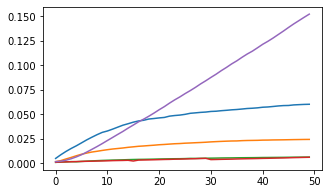

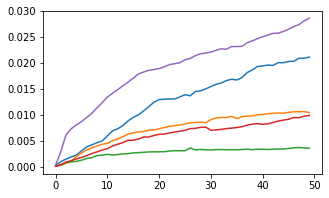

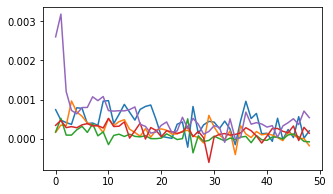

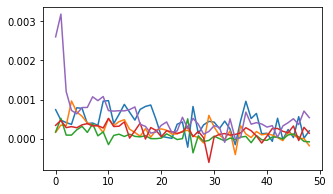

In [15]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        sumss_w, sumss_b = 0, 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            sumss_w = sumss_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][0] 
            sumss_b = sumss_b + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)][1]

        sumss_w = sumss_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]
        sumss_b = sumss_b/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var( sumss_w ))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var( sumss_b ))
        
        

for layer_index in num_layers_list:
    for tmp_int in range(len(globals()['var_accumulate_L{}_w'.format(layer_index)])-1):
        minus_w = globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_w'.format(layer_index)][tmp_int]
        minus_b = globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int + 1] - globals()['var_accumulate_L{}_b'.format(layer_index)][tmp_int]        
        globals()['var_changes_L{}_w'.format(layer_index)].append( minus_w )
        globals()['var_changes_L{}_b'.format(layer_index)].append( minus_b )
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.06204662, 0.0871028, 0.10314904, 0.109260954, 0.114722915, 0.12288327, 0.13259208, 0.14181432, 0.1493923, 0.15488708, 0.16170096, 0.16813111, 0.17415436, 0.17993562, 0.18677852, 0.19139473, 0.19467752, 0.19909248, 0.20418511, 0.20801872, 0.20975482, 0.21077792, 0.21308972, 0.21441746, 0.2164579, 0.21926358, 0.22044557, 0.22338253, 0.22507882, 0.22662562, 0.22846855, 0.229253, 0.23143186, 0.23296897, 0.23409261, 0.23300369, 0.23471938, 0.23785475, 0.23982194, 0.24228324, 0.24355562, 0.24451979, 0.24513388, 0.2470746, 0.24718025, 0.24805695, 0.24882957, 0.24967521, 0.2498516, 0.25012845]
[0.036773108, 0.047193658, 0.05969216, 0.06731823, 0.078117035, 0.08612602, 0.092576794, 0.097843796, 0.10163482, 0.105715305, 0.10883602, 0.112815194, 0.11549845, 0.118374385, 0.12141301, 0.12380278, 0.12570429, 0.12691912, 0.12901118, 0.12994249, 0.13200194, 0.1335395, 0.135011

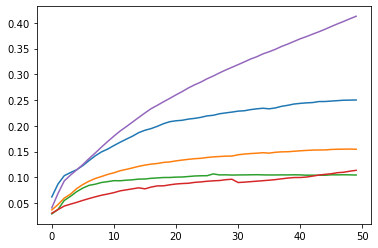

In [13]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch): #1이 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0    


for global_epoch in range(G_epoch-1):    #2가 맞음 = 바꾸지 말기
    for layer_index in num_layers_list:
        var_w = 0
        for sks in range(globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]):
            var_w = var_w + globals()['G{}_c{}_w_layer{}'.format(global_epoch, sks, layer_index)]

        var_w = var_w/globals()['G{}_num_clusters_in_layer{}_w'.format(global_epoch, layer_index)]

        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = var_w
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))

print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

[[0.825630247592926, 0.8088235259056091, 0.8235294222831726, 0.8235294222831726, 0.7983193397521973, 0.7983193397521973, 0.7899159789085388, 0.819327712059021, 0.8277310729026794, 0.8445377945899963, 0.8214285969734192, 0.756302535533905, 0.8046218752861023, 0.8382353186607361, 0.8361344337463379, 0.7941176295280457, 0.8151260614395142, 0.8004201650619507, 0.8172268867492676, 0.8172268867492676], [0.75, 0.7415966391563416, 0.7079831957817078, 0.7415966391563416, 0.7415966391563416, 0.6386554837226868, 0.6785714030265808, 0.7478991746902466, 0.825630247592926, 0.7710084319114685, 0.720588207244873, 0.7163865566253662, 0.6575630307197571, 0.680672287940979, 0.7142857313156128, 0.7079831957817078, 0.6533613204956055, 0.6932772994041443, 0.7331932783126831, 0.6890756487846375], [0.7815126180648804, 0.7542017102241516, 0.7815126180648804, 0.779411792755127, 0.7626050710678101, 0.7584033608436584, 0.7941176295280457, 0.7163865566253662, 0.7584033608436584, 0.7584033608436584, 0.7920168042182

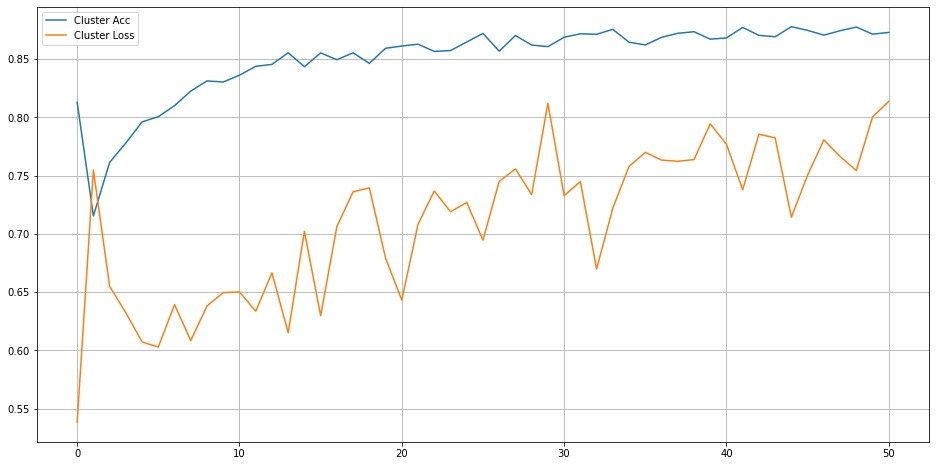

In [14]:
average_acc_cluster_list, average_loss_cluster_list = [], []


for i in range(len(Cluster_ACC)):    
    average_acc_cluster_list.append(np.mean(Cluster_ACC[i]))
    average_loss_cluster_list.append(np.mean(Cluster_LOSS[i]))

    
plt.figure(figsize=(16,8))
plt.plot(average_acc_cluster_list, label='Cluster Acc')
print(Cluster_ACC)
print(Cluster_LOSS,"\n\n\n")
plt.plot(average_loss_cluster_list, label='Cluster Loss')

plt.grid(True)
plt.legend()
plt.show()
